# Big Timber (6S0) ProbGust Reliablity

Calculate the reliability of ProbGust, and previous guidance.

## Import modules

In [1]:
import xarray            as xr
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import scipy.stats       as stats
import pint

## Set some contants

In [2]:
sns.set_theme(color_codes=True)
units = pint.UnitRegistry()
hour = pd.to_timedelta('1H')
normal_distribution = stats.norm()

## Define utility functions

### load_grid:
Load time series from a gridded source converting units and filtering fields. Also creates the valid time field from reference time and time since reference. Can tranform column names if needed, ie for NBM 1 hour forecast.

In [3]:
# def load_grid(filename, from_units=None, to_units=None, filter_fields=None, transform_columns=None):
#     data = xr.open_dataset(filename).to_dataframe()
#     if transform_columns is not None:
#         data.columns = transform_columns(data.columns)
#     if from_units is not None:
#         for field in from_units:
#             if field in data.columns:
#                 data[field] = pint.Quantity(data[field].to_numpy(), units(from_units[field])).to(units(to_units[field])).magnitude
#     data['valid_time'] = data[['reference_time', 'time_since_reference']].apply(lambda row: row['reference_time'] + row['time_since_reference'] * hour, axis=1)
#     if filter_fields is not None:
#         data = data.loc[:, ['reference_time', 'time_since_reference', 'valid_time'] + filter_fields].reset_index(drop=True)
#     return data
def load_forecast_grid(filename, filter_fields=None, transform_columns=None):
    data = xr.open_dataset(filename).to_dataframe()
    if transform_columns is not None:
        data.columns = data.columns.to_series().apply(transform_columns)
    data['valid_time'] = data.reference_time + data.time_since_reference * hour
    data = data.set_index(['reference_time', 'valid_time']).sort_index()
    if filter_fields is None:
        filter_fields = data.columns
    return data[filter_fields]

### convert_units
Convert units of columns in a DataFrame

In [4]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### filter_missing_data
Filter rows that are filled with NaNs, ignoring time fields by default

In [5]:
def filter_missing_data(data):
    return data.dropna(how='all')
# def filter_missing_data(data, exclude_fields=['valid_time', 'reference_time', 'time_since_reference']):
#     return data[np.invert(np.all(np.isnan(data[[x for x in data.columns if x not in exclude_fields]]), axis=1))]

### load_observations
Load time series from observation source, converting units and filtering fields.

In [6]:
def load_observations(filename, filter_fields=None):
    data = xr.open_dataset(filename).to_dataframe().set_index('time').sort_index()
    if filter_fields is not None:
        data = data.loc[:, filter_fields]
    return data
# def load_observations(filename, from_units=None, to_units=None, filter_fields=None):
#     data = xr.open_dataset(filename).to_dataframe()
#     if from_units is not None:
#         for field in from_units:
#             if field in data.columns:
#                 data[field] = pint.Quantity(data[field].to_numpy(), units(from_units[field])).to(units(to_units[field])).magnitude
#     if filter_fields is not None:
#         data = data.loc[:, ['time'] + filter_fields].reset_index(drop=True)
#     return data

### replace_missing_gust_with_wind
Since that gusts for AWOS/ASOS are not reported unless the gusts is sufficiently higher than sustained wind, replace missing gust values with the sustained to compare to RTMA / NBM that always has a gust value.

In [7]:
def replace_missing_gust_with_wind(data, wind_field, wind_gust_field):
    index = np.isnan(data[wind_gust_field])
    data.loc[index, wind_gust_field] = data[wind_field][index]
# def replace_missing_gust_with_wind(data, wind_field, wind_gust_field):
#     data.loc[np.isnan(data[wind_gust_field]), wind_gust_field] = data[np.isnan(data[wind_gust_field])][wind_field]
#     return data

### get_period_maximum
Find the maximum values when rounding the time fields to nearest time period

In [8]:
def get_period_maximum(data, period='1H'):
    return data.groupby(data.index.round(period)).max()
# def get_period_maximum(data, period='H'):
#     data.time = data.time.dt.round(period)
#     return data.groupby(['time']).max().reset_index()

### convert_units
Convert units of columns in a DataFrame

In [9]:
def convert_units(data, columns):
    for col in columns.keys():
        data[col] = pint.Quantity(data[col].to_numpy(), units(columns[col][0])).to(units(columns[col][1])).magnitude

### time_match_dataset
Time-match dataset while prefixing the columns of each dataset

In [10]:
def time_match_dataset(left, right, left_prefix='obs', right_prefix='grid', left_time='time', right_time='valid_time'):
    left_data = left.copy(deep=True)
    left_data.columns = ['{0:s}_{1:s}'.format(x, left_prefix) for x in left_data.columns]
    right_data = right.copy(deep=True)
    right_data.columns = ['{0:s}_{1:s}'.format(x, right_prefix) for x in right_data.columns]
    return pd.merge(left_data, right_data, how='inner', left_on='{0:s}_{1:s}'.format(left_time, left_prefix), right_on='{0:s}_{1:s}'.format(right_time, right_prefix)).reset_index()

### filter_three_hourly
Filter NBM data to 3 hourly forecast

In [11]:
def filter_three_hourly(data, time_field='valid_time'):
    return data[data.index.get_level_values(time_field).hour % 3 == 0]
#data[data[time_field].dt.round('3H') == data[time_field]]#.reset_index(drop=True)

### generate_probability
Calculate the Z-Score given the bias-corrected NBM mean wind gust and standard deviation

In [12]:
# def generate_probability(data, regression, threshold, unit='knots', tollerance = 0.6, field_name_base='prob_{0:s}'):
#     field_threshold = '{0:.0f}'.format(threshold)
#     threshold = pint.Quantity(threshold, units(unit)).to(units('knots')).magnitude
#     z_score = ((threshold - tollerance) - (regression.slope[0] * data['10_meter_wind_speed_of_gust_mean'] + regression.intercept[0])) / data['10_meter_wind_speed_of_gust_standard_deviation']
#     data[field_name_base.format(field_threshold)] = 100 * (1 - normal_distribution.cdf(z_score))
#     return data

def generate_prob_gust(data, threshold, unit='mph', tollerance = 0.6, mean='10_meter_wind_speed_of_gust_mean', standard_deviation='10_meter_wind_speed_of_gust_standard_deviation'):
    threshold = pint.Quantity(threshold - tollerance, units(unit)).to(units('m s**-1')).magnitude
    z_score = pd.Series((threshold - data[mean]) / data[standard_deviation], index=data.index)
    return pd.Series(np.round((100 * normal_distribution.sf(z_score))), index=data.index)


### standard_error_of_estimate
calculate the standard error from a slope and intercept

In [13]:
def standard_error_of_estimate(x, y, slope, intercept):
    x = np.array(x)
    y = np.array(y)
    error = np.inf
    if len(x) > 2:
        error = np.sqrt(np.sum(((slope * x + intercept) - y)**2) / (len(x) - 2))
    return error

### correction
Apply operational correction to the time-lagged NAM proability for 6S0

In [14]:
def correction(criteria, value):
    new_value = value
    if criteria == 50:
        if value < 6:
            new_value = 0
        elif (6 <= value) and (value < 10):
            new_value = 15
        elif (10 <= value) and (value < 20):
            new_value = 25
        elif (20 <= value) and (value < 40):
            new_value = 60
        else:
            new_value = 90
    elif criteria == 58:
        if value < 10:
            new_value = 0
        elif (10 <= value) and (value < 20):
            new_value = 5
        elif (20 <= value) and (value < 40):
            new_value = 25
        else:
            new_value = 55
    elif criteria == 70:
        if value < 10:
            new_value = 0
        elif (10 <= value) and (value < 20):
            new_value = 0
        elif (20 <= value) and (value < 40):
            new_value = 2
        else:
            new_value = 10
    return new_value

## Read Bias-Correction parameters

In [15]:
# regression = xr.open_dataset('../data/derived/6S0_regression.nc').to_dataframe()
regression = pd.read_json('../data/derived/regressions.json', orient='table')
regression

,slope,intercept,rvalue,pvalue,stderr
1KM,0.852204,5.806669,0.800694,1.319024e-211,0.020786
6S0,1.139874,2.580342,0.842540,0.000000e+00,0.015687


## Load Observation Data

In [16]:
obs =  load_observations('../data/observations/6S0.nc', 
                         filter_fields=['10_meter_wind_speed', '10_meter_wind_speed_of_gust', '10_meter_wind_from_direction'])
# convert_units(obs,{
#     '10_meter_wind_speed': ('m s**-1', 'knots'),
#     '10_meter_wind_speed_of_gust': ('m s**-1', 'knots')
# })
replace_missing_gust_with_wind(obs, '10_meter_wind_speed', '10_meter_wind_speed_of_gust')
obs = filter_missing_data(obs)
obs = get_period_maximum(obs, period='3H')
obs
# obs = get_period_maximum(filter_missing_data(replace_missing_gust_with_wind(load_observations('../data/observations/6S0.nc', from_units={'10_meter_wind_speed': 'm s**-1', '10_meter_wind_speed_of_gust': 'm s**-1'}, to_units={'10_meter_wind_speed': 'mph', '10_meter_wind_speed_of_gust': 'mph'}, filter_fields=['10_meter_wind_speed', '10_meter_wind_speed_of_gust']), '10_meter_wind_speed', '10_meter_wind_speed_of_gust')), period='3H')[['time', '10_meter_wind_speed_of_gust']]
# obs.columns = ['Valid Time (UTC)', 'Observed Gust (MPH)']
# obs

,10_meter_wind_speed,10_meter_wind_speed_of_gust,10_meter_wind_from_direction
time,,,
2018-11-06 15:00:00,4.115556,4.115556,50.0
2018-11-06 18:00:00,3.601111,3.601111,110.0
2018-11-06 21:00:00,4.115556,4.115556,60.0
2018-11-07 00:00:00,3.601111,3.601111,100.0
2018-11-07 03:00:00,2.057778,2.057778,120.0
...,...,...,...
2021-03-02 12:00:00,12.861111,12.861111,270.0
2021-03-02 15:00:00,10.803333,13.375556,270.0
2021-03-02 18:00:00,12.346667,15.433333,280.0


## Load NBM Forecast Data
calculate apply bias-correction and calculate ProbGust

In [17]:
nbm = load_forecast_grid('../data/nbm/NBM_6S0.nc', filter_fields=['10_meter_wind_speed_of_gust_mean', '10_meter_wind_speed_of_gust_standard_deviation'])

# convert_units(nbm,{
#     '10_meter_wind_speed_of_gust_mean': ('m s**-1', 'knots')
# })

nbm = filter_missing_data(nbm)
nbm['10_meter_wind_speed_of_gust_mean'] = regression.slope['6S0'] * nbm['10_meter_wind_speed_of_gust_mean'] + regression.intercept['6S0']
nbm_short = nbm[np.round((nbm.index.get_level_values('valid_time') - nbm.index.get_level_values('reference_time')).total_seconds()/3600.0) <= 36].copy(deep=True)
nbm_long = nbm[np.round((nbm.index.get_level_values('valid_time') - nbm.index.get_level_values('reference_time')).total_seconds()/3600.0) > 36].copy(deep=True)
nbm = filter_three_hourly(nbm)



smoothed_nbm = nbm.groupby(level='reference_time').apply(lambda s: s.rolling(window=3, min_periods=2, center=True).mean())

for threshold in [50, 58, 70]:
    nbm['ProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm, threshold)
    nbm['SmootehdNBMProbGust_{0:d}'.format(threshold)] = generate_prob_gust(smoothed_nbm, threshold)
    nbm_short['ShortProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm_short, threshold)
    nbm_long['LongProbGust_{0:d}'.format(threshold)] = generate_prob_gust(nbm_long, threshold)
nbm[[col.replace('ProbGust', 'ProbGustSmoothed') for col in nbm.columns if col.find('ProbGust') > -1]] = nbm.groupby(level='reference_time').apply(lambda s: s.rolling(window=3, min_periods=2, center=True).mean())[[col for col in nbm.columns if col.find('ProbGust') > -1]]
nbm[[col.replace('ProbGust', 'ProbGustTL') for col in nbm.columns if col.find('ProbGust') > -1]] = nbm.reset_index().set_index(['valid_time', 'reference_time']).sort_index(level=['valid_time', 'reference_time']).groupby(level='valid_time').apply(lambda s: s.rolling(window=12, min_periods=1).mean()).reset_index().set_index(['reference_time', 'valid_time']).sort_index(level=['reference_time', 'valid_time'])[[col for col in nbm.columns if col.find('ProbGust') > -1]]
nbm = nbm[[col for col in nbm.columns if col.find('ProbGust') > -1]]

nbm_short[[col.replace('ProbGust', 'ProbGustSmoothed') for col in nbm_short.columns if col.find('ProbGust') > -1]] = nbm_short.groupby(level='reference_time').apply(lambda s: s.rolling(window=7, min_periods=4, center=True).mean())[[col for col in nbm_short.columns if col.find('ProbGust') > -1]]
nbm_short = nbm_short[[col for col in nbm_short.columns if col.find('ProbGust') > -1]]
nbm_long[[col.replace('ProbGust', 'ProbGustSmoothed') for col in nbm_long.columns if col.find('ProbGust') > -1]] = nbm_long.groupby(level='reference_time').apply(lambda s: s.rolling(window=3, min_periods=2, center=True).mean())[[col for col in nbm_long.columns if col.find('ProbGust') > -1]]
nbm_long = nbm_long[[col for col in nbm_long.columns if col.find('ProbGust') > -1]]

nbm

ProbGust_50  SmootehdNBMProbGust_50  \
reference_time      valid_time                                                 
2020-10-01 09:00:00 2020-10-01 12:00:00          0.0                     0.0   
                    2020-10-01 15:00:00          0.0                     0.0   
                    2020-10-01 18:00:00          0.0                     0.0   
                    2020-10-01 21:00:00          0.0                     0.0   
                    2020-10-02 00:00:00          0.0                     0.0   
...                                              ...                     ...   
2021-02-28 21:00:00 2021-03-07 09:00:00          0.0                     0.0   
                    2021-03-07 12:00:00          0.0                     0.0   
                    2021-03-07 15:00:00          0.0                     0.0   
                    2021-03-07 18:00:00          0.0                     0.0   
                    2021-03-07 21:00:00          0.0                     0.0   

                                         ProbGust_58  SmootehdNBMProbGust_58  \
reference_time      valid_time                                                 
2020-10-01 09:00:00 2020-10-01 12:00:00          0.0                     0.0   
                    2020-10-01 15:00:00          0.0                     0.0   
                    2020-10-01 18:00:00          0.0                     0.0   
                    2020-10-01 21:00:00          0.0                     0.0   
                    2020-10-02 00:00:00          0.0                     0.0   
...                                              ...                     ...   
2021-02-28 21:00:00 2021-03-07 09:00:00          0.0                     0.0   
                    2021-03-07 12:00:00          0.0                     0.0   
                    2021-03-07 15:00:00          0.0                     0.0   
                    2021-03-07 18:00:00          0.0                     0.0   
                    2021-03-07 21:00:00          0.0                     0.0   

                                         ProbGust_70  SmootehdNBMProbGust_70  \
reference_time      valid_time                                                 
2020-10-01 09:00:00 2020-10-01 12:00:00          0.0                     0.0   
                    2020-10-01 15:00:00          0.0                     0.0   
                    2020-10-01 18:00:00          0.0                     0.0   
                    2020-10-01 21:00:00          0.0                     0.0   
                    2020-10-02 00:00:00          0.0                     0.0   
...                                              ...                     ...   
2021-02-28 21:00:00 2021-03-07 09:00:00          0.0                     0.0   
                    2021-03-07 12:00:00          0.0                     0.0   
                    2021-03-07 15:00:00          0.0                     0.0   
                    2021-03-07 18:00:00          0.0                     0.0   
                    2021-03-07 21:00:00          0.0                     0.0   

                                         ProbGustSmoothed_50  \
reference_time      valid_time                                 
2020-10-01 09:00:00 2020-10-01 12:00:00                  0.0   
                    2020-10-01 15:00:00                  0.0   
                    2020-10-01 18:00:00                  0.0   
                    2020-10-01 21:00:00                  0.0   
                    2020-10-02 00:00:00                  0.0   
...                                                      ...   
2021-02-28 21:00:00 2021-03-07 09:00:00                  0.0   
                    2021-03-07 12:00:00                  0.0   
                    2021-03-07 15:00:00                  0.0   
                    2021-03-07 18:00:00                  0.0   
                    2021-03-07 21:00:00                  0.0   

                                         SmootehdNBMProbGustSmoothed_50  \
reference_

## Load Operation Probability Guidance

In [18]:
previous = xr.open_dataset('../data/database/K6S0model.nc').to_dataframe()
previous = previous.fillna(0)
previous = previous[(previous.model == 'NAM')][['run', 'valid', 'WrnProb']].sort_values(['valid', 'run']).reset_index(drop=True)
previous.columns = ['reference_time', 'valid_time', 'OriginalWarningProb_58']
previous = previous.set_index(['reference_time', 'valid_time'])
previous['TimeLaggedWarningProb_58'] = previous.groupby(level='reference_time').apply(lambda s: s.rolling(window=12, min_periods=1).mean())['OriginalWarningProb_58']

for threshold in [50, 58, 70]:
    previous['OperationalProb_{0:d}'.format(threshold)] = previous['TimeLaggedWarningProb_58'].apply(lambda a: correction(threshold, a))
# previous['WrnProbTL'] = previous.groupby(['Valid Time (UTC)']).WrnProb.rolling(window=12, min_periods=1).mean().reset_index().sort_values('level_1').WrnProb
# thresholds = [50, 60, 70]
# for t in thresholds:
#     previous['Prob{0:d}TL'.format(t)] = previous['WrnProbTL'].apply(lambda a: correction(t, a))
# previous['NAM Cycle'] += pd.to_timedelta('9H')
previous

OriginalWarningProb_58  \
reference_time      valid_time                                    
2014-01-13 18:00:00 2014-01-13 18:00:00                     0.0   
                    2014-01-13 21:00:00                     0.0   
                    2014-01-14 00:00:00                     0.0   
2014-01-14 00:00:00 2014-01-14 00:00:00                     0.0   
2014-01-13 18:00:00 2014-01-14 03:00:00                     0.0   
...                                                         ...   
2021-03-22 18:00:00 2021-03-25 21:00:00                     1.0   
2021-03-22 12:00:00 2021-03-26 00:00:00                     1.0   
2021-03-22 18:00:00 2021-03-26 00:00:00                     0.0   
                    2021-03-26 03:00:00                     0.0   
                    2021-03-26 06:00:00                     0.0   

                                         TimeLaggedWarningProb_58  \
reference_time      valid_time                                      
2014-01-13 18:00:00 2014-01-13 18:00:00                  0.000000   
                    2014-01-13 21:00:00                  0.000000   
                    2014-01-14 00:00:00                  0.000000   
2014-01-14 00:00:00 2014-01-14 00:00:00                  0.000000   
2014-01-13 18:00:00 2014-01-14 03:00:00                  0.000000   
...                                                           ...   
2021-03-22 18:00:00 2021-03-25 21:00:00                  4.166667   
2021-03-22 12:00:00 2021-03-26 00:00:00                  5.166667   
2021-03-22 18:00:00 2021-03-26 00:00:00                  3.833333   
                    2021-03-26 03:00:00                  3.416667   
                    2021-03-26 06:00:00                  3.000000   

                                         OperationalProb_50  \
reference_time      valid_time                                
2014-01-13 18:00:00 2014-01-13 18:00:00                   0   
                    2014-01-13 21:00:00                   0   
                    2014-01-14 00:00:00                   0   
2014-01-14 00:00:00 2014-01-14 00:00:00                   0   
2014-01-13 18:00:00 2014-01-14 03:00:00                   0   
...                                                     ...   
2021-03-22 18:00:00 2021-03-25 21:00:00                   0   
2021-03-22 12:00:00 2021-03-26 00:00:00                   0   
2021-03-22 18:00:00 2021-03-26 00:00:00                   0   
                    2021-03-26 03:00:00                   0   
                    2021-03-26 06:00:00                   0   

                                         OperationalProb_58  \
reference_time      valid_time                                
2014-01-13 18:00:00 2014-01-13 18:00:00                   0   
                    2014-01-13 21:00:00                   0   
                    2014-01-14 00:00:00                   0   
2014-01-14 00:00:00 2014-01-14 00:00:00                   0   
2014-01-13 18:00:00 2014-01-14 03:00:00                   0   
...                                                     ...   
2021-03-22 18:00:00 2021-03-25 21:00:00                   0   
2021-03-22 12:00:00 2021-03-26 00:00:00                   0   
2021-03-22 18:00:00 2021-03-26 00:00:00                   0   
                    2021-03-26 03:00:00                   0   
                    2021-03-26 06:00:00                   0   

                                         OperationalProb_70  
reference_time      valid_time                               
2014-01-13 18:00:00 2014-01-13 18:00:00                   0  
                    2014-01-13 21:00:00                   0  
                    2014-01-14 00:00:00                   0  
2014-01-14 00:00:00 2014-01-14 00:00:00                   0  
2014-01-13 18:00:00 2014-01-14 03:00:00                   0  
...                                                     ...  
2021-03-22 18:00:00 2021-03-25 21:00:00                   0  
2021-03-22 12:00:00 2021-03-26 00:00:00                   0  
2021-03-22 

In [19]:

# pd.merge(left=nbm, right=obs[['10_meter_wind_speed_of_gust']].rename_axis('valid_time'), right_index=True, left_index=True, how='inner')

## Time-match Observations, NBM, and Operational Guidance

In [20]:
# data = pd.merge(left=nbm, right=previous, left_on=['NBM Cycle', 'Valid Time (UTC)'], right_on=['NAM Cycle', 'Valid Time (UTC)'], how='outer')[['NBM Cycle', 'Valid Time (UTC)'] + ['ProbGust{0:d}'.format(t) for t in [50, 58, 70]] + ['ProbGust{0:d}_MovingAvg'.format(t) for t in [50, 58, 70]] + ['WrnProb', 'WrnProbTL'] + ['Prob{0:d}TL'.format(t) for t in [50, 60, 70]]]
# data.columns = ['NBM Cycle', 'Valid Time (UTC)'] + ['ProbGust{0:d}'.format(t) for t in [50, 58, 70]] + ['ProbGust{0:d}_MovingAvg'.format(t) for t in [50, 58, 70]] + ['Original WrnProb', 'Original WrnProb Time-lagged'] + ['Oper. WrnProb{0:d} Time-lagged'.format(t) for t in [50, 60, 70]]

# for col in [x for x in data.columns if x not in ['Valid Time (UTC)', 'NBM Cycle'] + ['Prob{0:d}TL'.format(t) for t in [50, 60, 70]]]:
#     data[col] = np.round(data[col] / 5) * 5

# data = pd.merge(obs, data[[x for x in data.columns if x != 'NBM Cycle']].melt(id_vars=['Valid Time (UTC)'], var_name='Method', value_name='Probability'), how='inner', left_on='Valid Time (UTC)', right_on='Valid Time (UTC)').dropna()
# verify_citeria = dict(zip(['ProbGust50', 'ProbGust58', 'ProbGust70', 'ProbGust50_MovingAvg','ProbGust58_MovingAvg', 'ProbGust70_MovingAvg', 'Original WrnProb','Original WrnProb Time-lagged', 'Oper. WrnProb50 Time-lagged','Oper. WrnProb60 Time-lagged', 'Oper. WrnProb70 Time-lagged'],
#                           [ 50,           58,           70,           50,                    58,                     70,                     58,                58,                             50,                           58,                            70]))
# data['Criteria'] = data.Method.apply(verify_citeria.get)
# data['Hit'] = data.apply(lambda a: a['Observed Gust (MPH)'] >= a.Criteria, axis=1)
# reliablity = data[['Method', 'Probability', 'Hit']].groupby(['Method','Probability']).Hit.apply(lambda a: (a.sum()/a.count() * 10) * 10).reset_index()
# reliablity
data = pd.merge(left=pd.concat([previous.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value'),
                                     nbm.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value'),
                               nbm_short.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value'),
                                nbm_long.reset_index().melt(id_vars=['reference_time', 'valid_time'], var_name='Dataset', value_name='Value')]).set_index(['reference_time', 'valid_time']).sort_index(), 
                right=obs[['10_meter_wind_speed_of_gust']].rename_axis('valid_time'), right_index=True, left_index=True, how='inner')
data.Value = (data.Value / 5).round() * 5

data['Criteria'] = pint.Quantity(data.Dataset.str.split('_', expand=True)[[1]].astype('uint8'), units('mph')).to(units('m s**-1')).magnitude
data['Hit'] = data.apply(lambda row: row['10_meter_wind_speed_of_gust'] >= row['Criteria'], axis=1)
reliability = data[['Dataset', 'Value', 'Hit']].groupby(['Dataset', 'Value']).Hit.apply(lambda a: (a.sum()/a.count() * 100)).reset_index()
reliability

,Dataset,Value,Hit
0,LongProbGustSmoothed_50,0.0,5.663734
1,LongProbGustSmoothed_50,5.0,20.952381
2,LongProbGustSmoothed_50,10.0,22.346369
3,LongProbGustSmoothed_50,15.0,35.840708
4,LongProbGustSmoothed_50,20.0,29.341317
...,...,...,...
663,TimeLaggedWarningProb_58,80.0,24.242424
664,TimeLaggedWarningProb_58,85.0,28.571429
665,TimeLaggedWarningProb_58,90.0,42.857143
666,TimeLaggedWarningProb_58,95.0,75.000000


## Generate Reliability Regressions

In [21]:
# reliability_regressions = None
# for method in reliablity.Method.unique():
#     method_data = reliablity[reliablity.Method == method]
#     method_regression = pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'stderr_perfect'], list(stats.linregress(method_data.Probability, method_data.Hit)) + [0])), index=[method])
#     method_regression.loc[method, 'stderr'] = standard_error_of_estimate(method_data.Probability, method_data.Hit, method_regression['slope'][method], method_regression['intercept'][method])
#     method_regression.loc[method, 'stderr_perfect'] = standard_error_of_estimate(method_data.Probability, method_data.Hit, 1.0, 0.0)
#     if reliability_regressions is None:
#         reliability_regressions = method_regression
#     else:
#         reliability_regressions = pd.concat([reliability_regressions, method_regression])
# reliability_regressions
reliability_regressions = None
for dataset in reliability.Dataset.unique():
    dataset_data = reliability[reliability.Dataset == dataset]
    dataset_regression = pd.DataFrame(dict(zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr', 'stderr_perfect'], list(stats.linregress(dataset_data.Value, dataset_data.Hit)) + [0])), index=[dataset])
    dataset_regression.loc[dataset, 'stderr'] = standard_error_of_estimate(dataset_data.Value, dataset_data.Hit, dataset_regression['slope'][dataset], dataset_regression['intercept'][dataset])
    dataset_regression.loc[dataset, 'stderr_perfect'] = standard_error_of_estimate(dataset_data.Value, dataset_data.Hit, 1.0, 0.0)
    if reliability_regressions is None:
        reliability_regressions = dataset_regression
    else:
        reliability_regressions = pd.concat([reliability_regressions, dataset_regression])
reliability_regressions.to_csv('output/6S0Reliability.csv')
reliability_regressions

,slope,intercept,rvalue,pvalue,stderr,stderr_perfect
LongProbGustSmoothed_50,0.827074,13.705555,0.976267,4.391357e-14,5.839970,9.627699
LongProbGustSmoothed_58,0.543763,23.469617,0.583209,8.767196e-03,21.927849,25.786911
LongProbGustSmoothed_70,0.468046,11.365881,0.271040,4.201442e-01,29.055714,30.582118
LongProbGust_50,0.625222,18.444592,0.940517,2.359205e-10,7.188878,13.931342
LongProbGust_58,0.566932,23.796502,0.752425,1.295777e-04,15.082927,20.304630
LongProbGust_70,0.159207,16.080162,0.126942,6.654162e-01,27.083170,34.872558
OperationalProb_50,0.530066,0.672092,0.998658,5.898255e-05,1.158539,29.764559
OperationalProb_58,0.509643,0.658673,0.997048,2.951933e-03,1.199660,20.412728
OperationalProb_70,1.023972,0.176949,1.000000,0.000000e+00,inf,inf
OriginalWarningProb_58,0.458554,-0.800547,0.831670,2.976270e-06,9.745023,35.364669


## Generate Reliability Plots

['OriginalWarningProb', 'TimeLaggedWarningProb', 'OperationalProb', 'ProbGust', 'ProbGustSmoothed', 'SmootehdNBMProbGust', 'SmootehdNBMProbGustSmoothed', 'ProbGustTL', 'ProbGustTLSmoothed', 'SmootehdNBMProbGustTL', 'SmootehdNBMProbGustTLSmoothed', 'ShortProbGust', 'ShortProbGustSmoothed', 'LongProbGust', 'LongProbGustSmoothed']


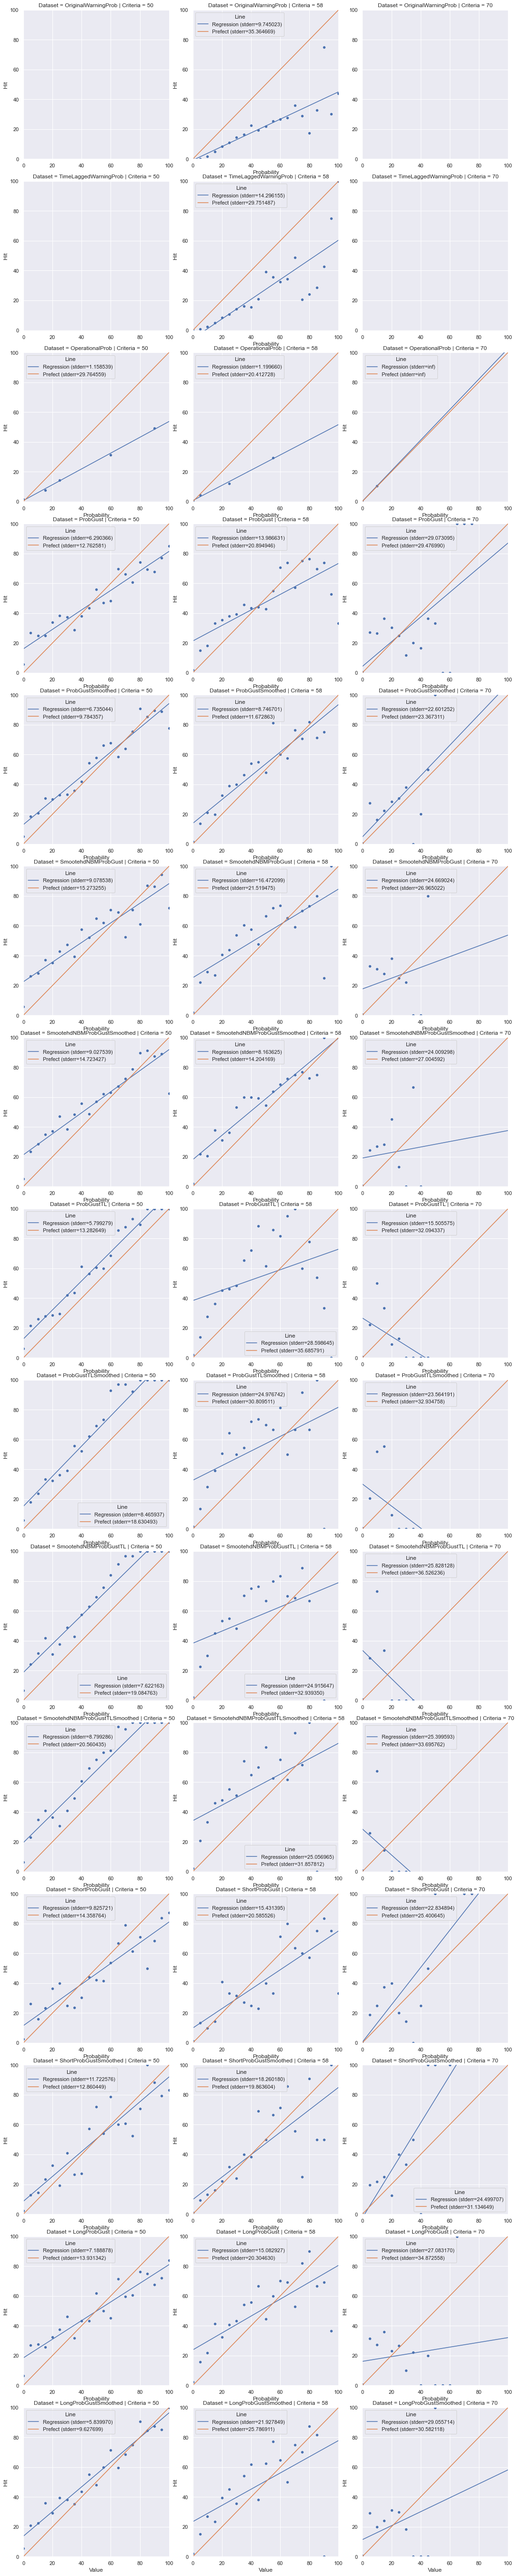

In [22]:
plot_data = reliability.copy(deep=True)
plot_data['Criteria'] = plot_data.Dataset.str.split('_', expand=True)[[1]]
plot_data.Dataset = plot_data.Dataset.str.split('_', expand=True)[[0]]

dataset_order = ['OriginalWarningProb', 'TimeLaggedWarningProb', 'OperationalProb', 'ProbGust', 'ProbGustSmoothed', 'SmootehdNBMProbGust', 'SmootehdNBMProbGustSmoothed', 'ProbGustTL', 'ProbGustTLSmoothed', 'SmootehdNBMProbGustTL', 'SmootehdNBMProbGustTLSmoothed', 'ShortProbGust', 'ShortProbGustSmoothed', 'LongProbGust', 'LongProbGustSmoothed']
dataset_order += [col for col in plot_data.columns if col not in dataset_order and col not in ['Dataset', 'Value', 'Hit', 'Criteria']]
print(dataset_order)
g = sns.relplot(data=plot_data, x='Value', y='Hit', col='Criteria', row='Dataset', row_order=dataset_order, facet_kws=dict(ylim=(0,100), xlim=(0,100), sharex=False, sharey=False))
for plot_vars, ax in g.axes_dict.items():
    method = '_'.join(plot_vars)
    if method in reliability_regressions.index:
        curve_data = pd.DataFrame({'Probability': np.array([0,100]),
               'Regression (stderr={0:f})'.format(reliability_regressions['stderr'][method]): reliability_regressions['slope'][method] * np.array([0,100]) + reliability_regressions['intercept'][method],
               'Prefect (stderr={0:f})'.format(reliability_regressions['stderr_perfect'][method]): np.array([0,100])}).melt(id_vars=['Probability'], var_name='Line', value_name='Hit')
        sns.lineplot(data=curve_data, x='Probability', y='Hit', hue='Line', ax=ax)
g.savefig('output/reliablity.png')

In [23]:
obs[obs['Observed Gust (MPH)'] >= 50].count()

KeyError: 'Observed Gust (MPH)'